In [21]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
!pip install newspaper3k
from newspaper import Article
from textblob import TextBlob
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings("ignore", category=FutureWarning)


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

In [23]:
# Function to fetch historical data for a given ticker and period
def fetch_data(ticker, period):
    stock = yf.Ticker(ticker)
    return stock.history(period=period)


def plot_stock(data, label, color):
    plt.plot(data.index, data['Close'], label=f"{label} Close Price", color=color)


# Function to calculate and plot normalized data
def plot_normalized_data(data, ticker, color, subplot):
    rolling_mean = data["Close"].rolling(window=30).mean()
    normalized_data = data["Close"] / rolling_mean
    subplot.plot(data.index, normalized_data, label=ticker, color=color)
    subplot.set_title(f"Normalized Stock Prices for {ticker}")
    subplot.set_ylabel("Normalized Closing Price")

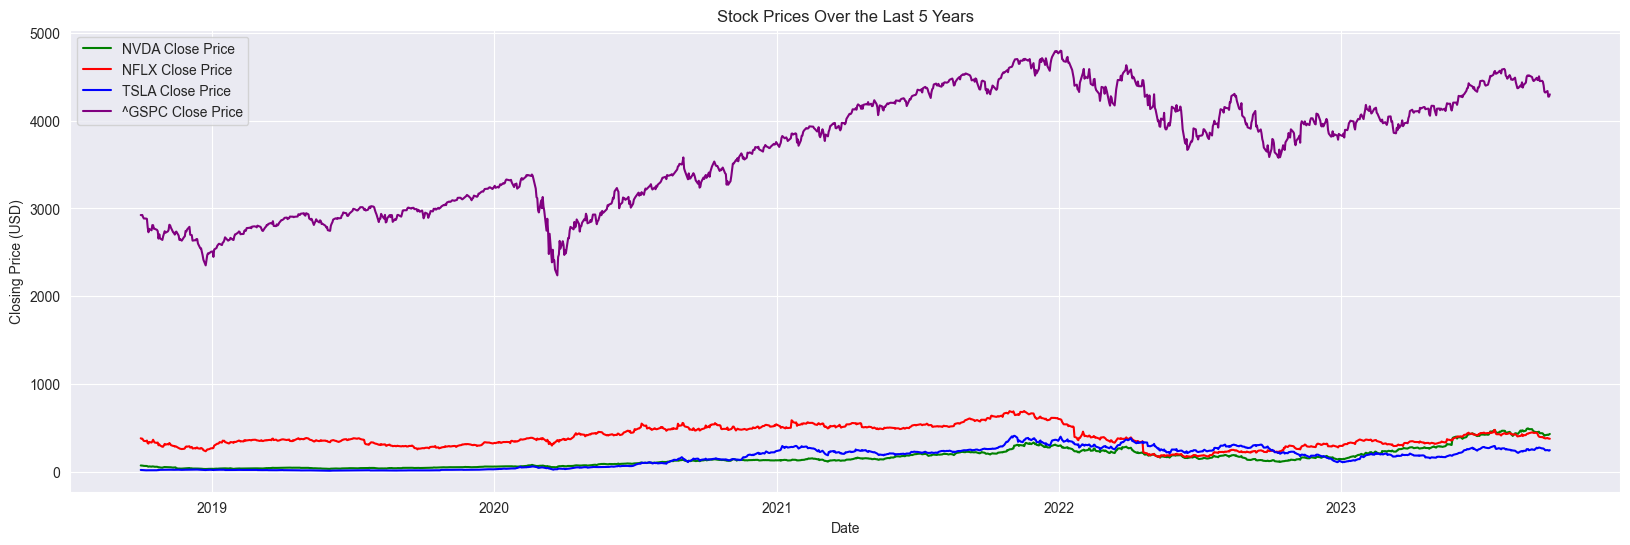

In [24]:
# Tickers and period
tickers = ["NVDA", "NFLX", "TSLA","^GSPC"]
colors = ["green", "red", "blue", "purple" ]# Added "^GSPC" for S&P 500
ticker_colors = {ticker: color for ticker, color in zip(tickers, colors)}
period = "5y"

# Fetch and plot historical data for each stock
plt.figure(figsize=(20, 6))
  # Added a color for S&P 500
for ticker, color in zip(tickers, colors):
    stock_data = fetch_data(ticker, period)
    plot_stock(stock_data, ticker, color)

plt.title("Stock Prices Over the Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

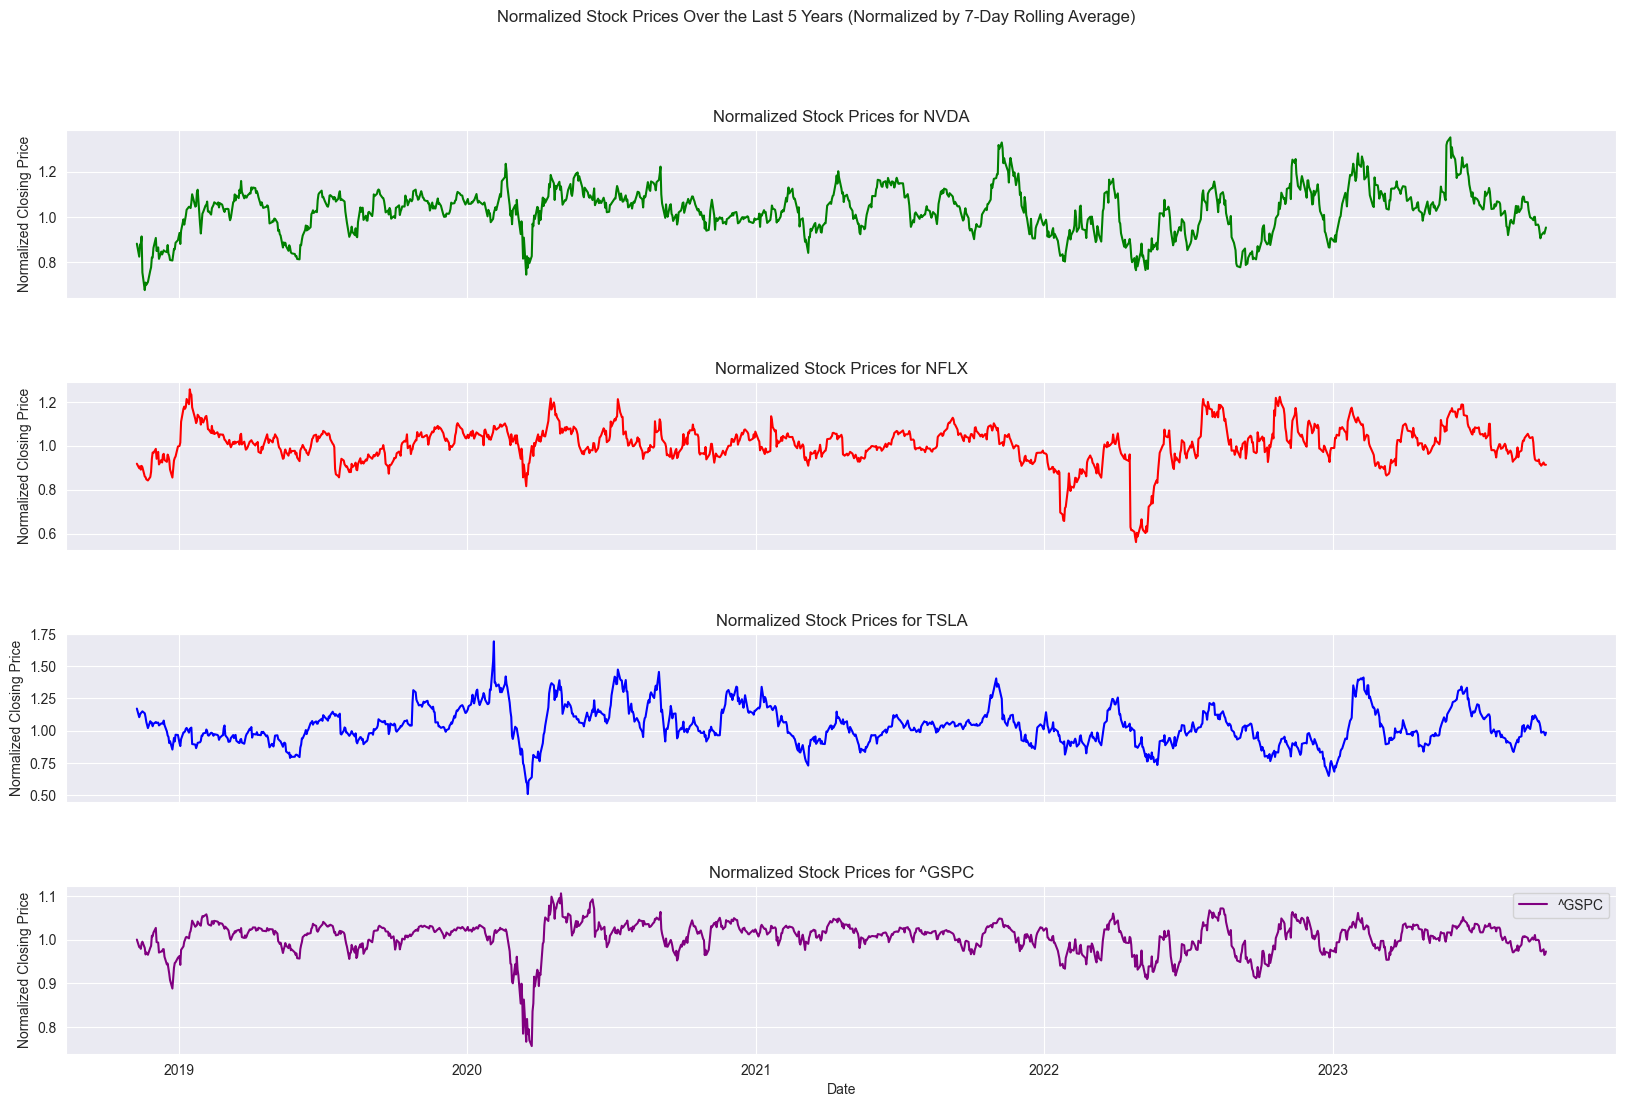

In [25]:
# Create a figure with multiple subplots for normalized data
fig, axs = plt.subplots(len(tickers), 1, figsize=(20, 12), sharex=True)

# Fetch and plot normalized data for each stock
for i, (ticker, color) in enumerate(zip(tickers, colors)):
    stock_data = fetch_data(ticker, period)
    plot_normalized_data(stock_data, ticker, color, axs[i])

plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
plt.suptitle("Normalized Stock Prices Over the Last 5 Years (Normalized by 7-Day Rolling Average)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

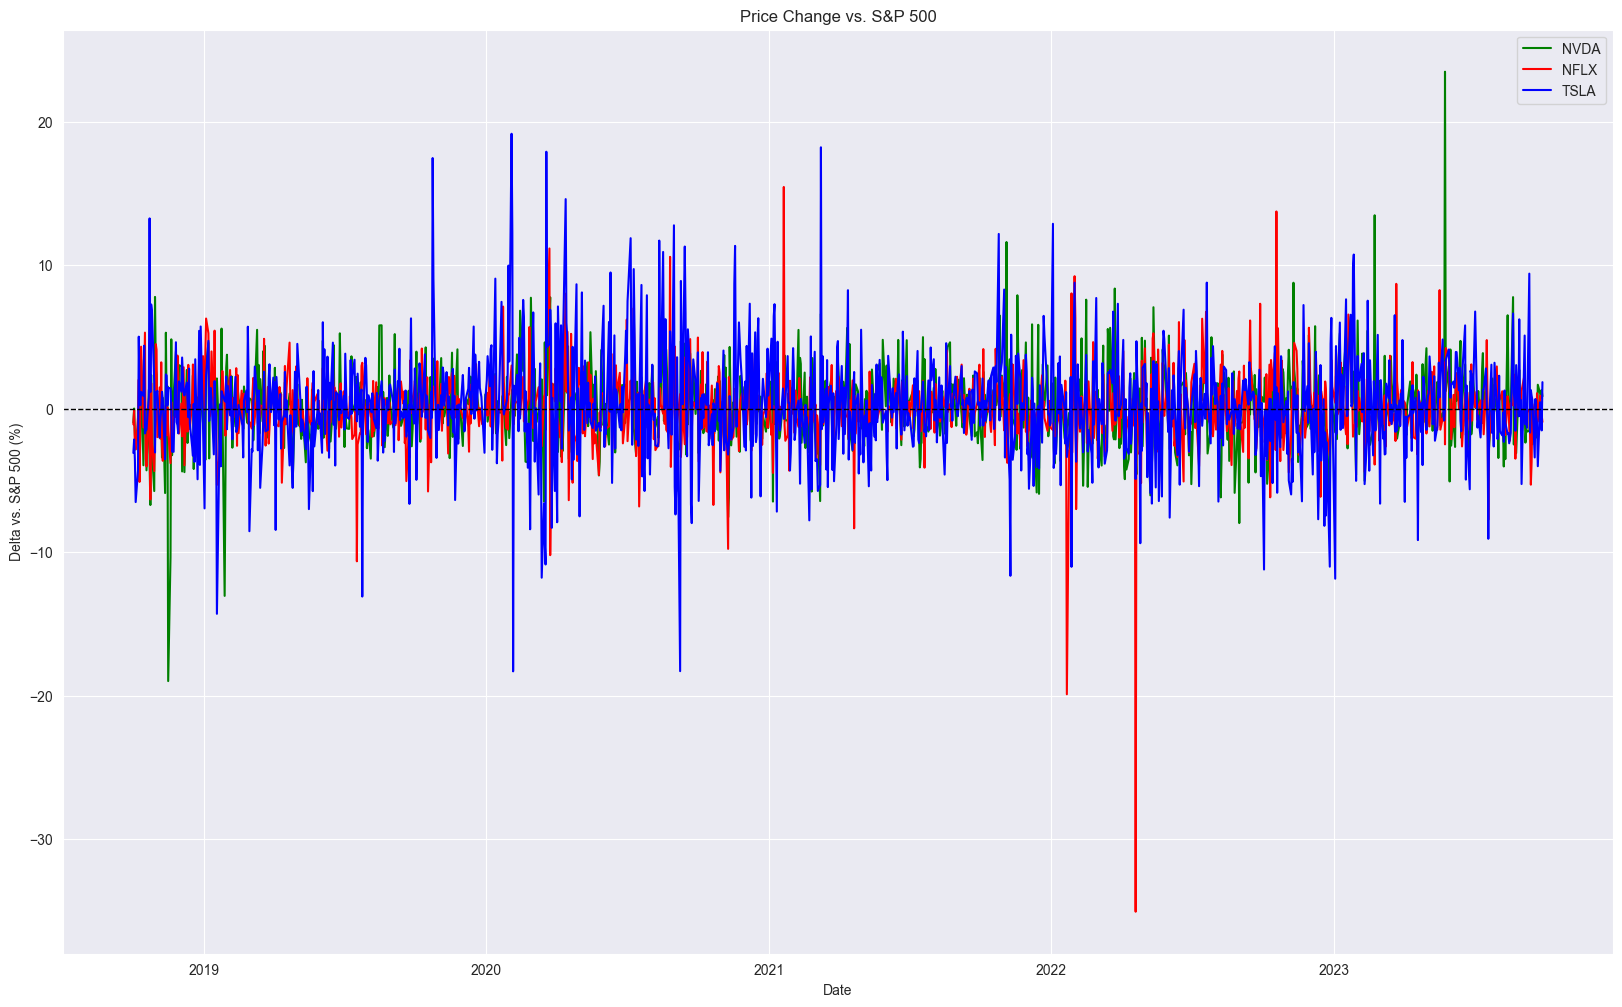

In [26]:
data = {}
for ticker in tickers:
    data[ticker] = fetch_data(ticker, period)

# Calculate daily price delta (percentage change) for each stock and the S&P 500
for ticker in data:
    data[ticker]['Delta'] = data[ticker]['Close'].pct_change() * 100

# Calculate the difference between each stock's delta and the S&P 500 delta
for ticker in tickers[:-1]:  # Exclude S&P 500 in the loop
    data[ticker]['Delta vs S&P 500'] = data[ticker]['Delta'] - data['^GSPC']['Delta']

# Create a plot to visualize the differences
plt.figure(figsize=(20, 12))
for ticker, color in zip(tickers[:-1], colors[:-1]):  # Exclude S&P 500
    plt.plot(data[ticker].index, data[ticker]['Delta vs S&P 500'], label=ticker, color=color)

plt.title("Price Change vs. S&P 500")
plt.xlabel("Date")
plt.ylabel("Delta vs. S&P 500 (%)")
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.show()

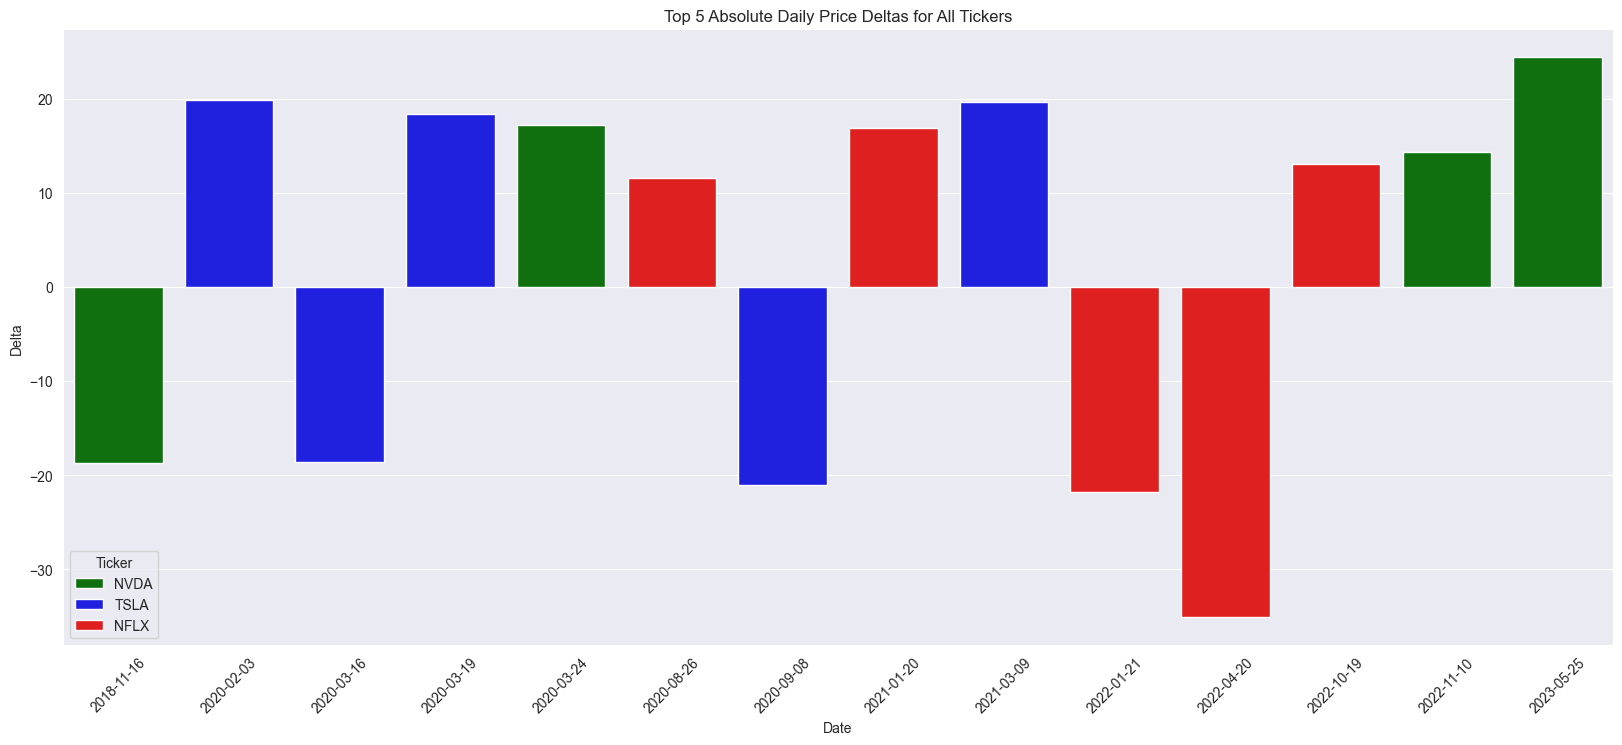

In [27]:
# Create a color palette for the tickers

# Create an empty DataFrame to store all the top deltas
all_top_deltas = pd.DataFrame(columns=['Date', 'Delta', 'Ticker'])

# Populate the DataFrame with data from each ticker
for i, ticker in enumerate(tickers[:-1]):  # Exclude S&P 500
    top_absolute_deltas = data[ticker]['Delta'].abs().nlargest(5)
    top_deltas_with_signal = data[ticker].loc[top_absolute_deltas.index]

    # Sort the data by date (earliest to latest)
    top_deltas_with_signal.sort_index(inplace=True)  # Added this line to sort by date

    # Format the date in a more readable way
    top_deltas_with_signal['Date'] = top_deltas_with_signal.index.strftime('%d-%m-%Y')

    # Add the ticker information
    top_deltas_with_signal['Ticker'] = ticker

    # Concatenate the data for this ticker to all_top_deltas
    all_top_deltas = pd.concat([all_top_deltas, top_deltas_with_signal])  # Concatenate data for this ticker

# Sort the entire DataFrame by Date (earliest to latest) and Delta (highest to lowest)
all_top_deltas['Date'] = pd.to_datetime(all_top_deltas['Date'], format='%d-%m-%Y')
all_top_deltas = all_top_deltas.sort_values(by=['Date', 'Delta'], ascending=[True, False])

# Modify the DataFrame to keep only the date portion
all_top_deltas['Date'] = all_top_deltas['Date'].dt.date  # Keep only the date portion

# Create a single bar chart for all top deltas with different colors
plt.figure(figsize=(20, 8))


# Set dodge=False to reduce the gap between bars
sns.barplot(x='Date', y='Delta', hue='Ticker', data=all_top_deltas, palette=ticker_colors, dodge=False)

plt.xlabel('Date')
plt.ylabel('Delta')
plt.title('Top 5 Absolute Daily Price Deltas for All Tickers')
plt.xticks(rotation=45)
plt.legend(title='Ticker')

# Show the single chart
plt.show()


In [28]:
print(all_top_deltas.to_string(index=False))
#nvidia site:https://www.bloomberg.com OR site:https://www.infomoney.com OR site:https://www.reuters.com OR site:https://www.wsj.com OR site:https://finance.google.com OR site:https://finance.yahoo.com


      Date      Delta Ticker       Open       High        Low      Close      Volume  Dividends  Stock Splits  Delta vs S&P 500
2018-11-16 -18.755878   NVDA  40.475917  42.295003  40.052123  40.751007 196352000.0        0.0           0.0        -18.978208
2020-02-03  19.894859   TSLA  44.912666  52.409332  44.901333  52.000000 705975000.0        0.0           0.0         19.169398
2020-03-16 -18.452079   NVDA  52.932099  56.343617  48.344367  48.942440  72697200.0        0.0           0.0         -6.468024
2020-03-16 -18.577806   TSLA  31.299999  32.991333  29.478001  29.671333 307342500.0        0.0           0.0         -6.593751
2020-03-19  18.387684   TSLA  24.980000  30.133333  23.897333  28.509333 452932500.0        0.0           0.0         17.916903
2020-03-24  17.156434   NVDA  57.066295  62.962315  56.829557  62.095104 110164400.0        0.0           0.0          7.773660
2020-08-26  11.608717   NFLX 492.500000 549.039978 492.079987 547.530029  20373700.0        0.0         

In [29]:
# Sample text for analysis
# Sample texts for analysis
sample_texts = [
    "I love this product! It's amazing.",
    "I don't like rainy days.",
    "The concert was fantastic!",
    "This movie is terrible.",
    "The weather is so-so today.",
]

# Analyze sentiment using TextBlob and VADER Sentiment
for sample_text in sample_texts:
    # TextBlob sentiment analysis
    text_blob = TextBlob(sample_text)
    tb_sentiment = text_blob.sentiment
    tb_polarity = tb_sentiment.polarity

    # Determine TextBlob sentiment label
    if tb_polarity > 0:
        tb_sentiment_label = "Positive"
    elif tb_polarity < 0:
        tb_sentiment_label = "Negative"
    else:
        tb_sentiment_label = "Neutral"

    # VADER Sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    vs_sentiment = analyzer.polarity_scores(sample_text)
    vs_polarity = vs_sentiment['compound']

    # Determine VADER Sentiment label
    if vs_polarity > 0.05:
        vs_sentiment_label = "Positive"
    elif vs_polarity < -0.05:
        vs_sentiment_label = "Negative"
    else:
        vs_sentiment_label = "Neutral"

    # Print results
    print("Sample Text:", sample_text)
    print("TextBlob Sentiment Polarity:", tb_polarity)
    print("TextBlob Sentiment Label:", tb_sentiment_label)
    print("VADER Sentiment Polarity:", vs_polarity)
    print("VADER Sentiment Label:", vs_sentiment_label)
    print("\n")

Sample Text: I love this product! It's amazing.
TextBlob Sentiment Polarity: 0.6125
TextBlob Sentiment Label: Positive
VADER Sentiment Polarity: 0.8516
VADER Sentiment Label: Positive


Sample Text: I don't like rainy days.
TextBlob Sentiment Polarity: 0.0
TextBlob Sentiment Label: Neutral
VADER Sentiment Polarity: -0.2235
VADER Sentiment Label: Negative


Sample Text: The concert was fantastic!
TextBlob Sentiment Polarity: 0.5
TextBlob Sentiment Label: Positive
VADER Sentiment Polarity: 0.5983
VADER Sentiment Label: Positive


Sample Text: This movie is terrible.
TextBlob Sentiment Polarity: -1.0
TextBlob Sentiment Label: Negative
VADER Sentiment Polarity: -0.4767
VADER Sentiment Label: Negative


Sample Text: The weather is so-so today.
TextBlob Sentiment Polarity: 0.0
TextBlob Sentiment Label: Neutral
VADER Sentiment Polarity: 0.0
VADER Sentiment Label: Neutral




In [30]:
foo = Article("https://finance.yahoo.com/news/netflix-q1-earnings-2020-194103428.html")
foo.download()
foo.html
foo.parse()

  Ticket  Count
0   nflx     51
1   nvda     52
2   tsla     52


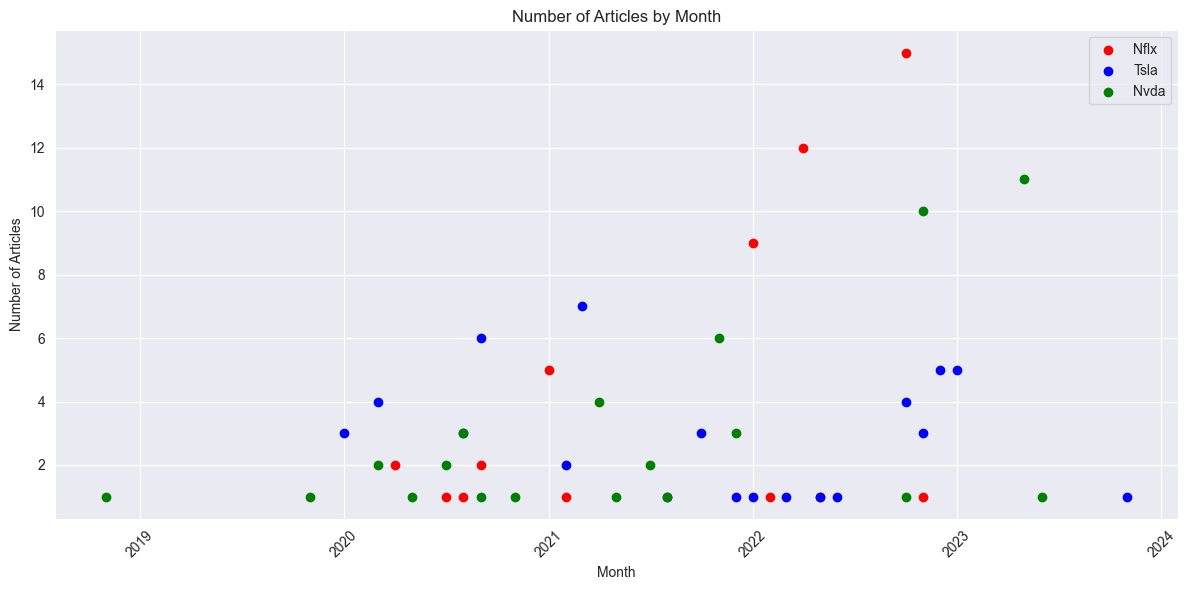

In [37]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the paths to the JSON files
file_paths = [
    "data/netflix.json",
    "data/tesla.json",
    "data/nvidia.json"
]

# Create an empty list to store DataFrames
dfs = []

# Iterate through JSON files and extract data
for file_path in file_paths:
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
        ticket = data["ticket"]
        articles = data["articles"]
        for article in articles:
            publish_date = article["publish_date"]
            dfs.append(pd.DataFrame({"Date": [publish_date], "Ticket": [ticket]}))

# Concatenate the list of DataFrames into one DataFrame
data_df = pd.concat(dfs, ignore_index=True)

# Convert the Date column to a pandas datetime object
data_df["Date"] = pd.to_datetime(data_df["Date"], format="%m/%d/%Y")

# Group the data by month and ticket and count the number of articles
grouped_data = data_df.groupby([data_df["Date"].dt.to_period("M"), "Ticket"]).size().reset_index(name="Count")

# Create the scatter plot
plt.figure(figsize=(12, 6))

# Iterate through unique tickets and plot for each ticket with a different color
# Iterate through unique tickets and plot for each ticket with a different color
colors = {"nflx": "red", "tsla": "blue", "nvda": "green"}
for ticket, color in colors.items():
    subset = grouped_data[grouped_data["Ticket"] == ticket]

    # Use .loc to modify the DataFrame
    subset.loc[:, "Date"] = subset["Date"].dt.to_timestamp()

    plt.scatter(subset["Date"], subset["Count"], label=ticket.capitalize(), color=color)


# Customize the plot
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.title("Number of Articles by Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
# Calculate the total number of articles by ticket
total_articles_by_ticket = grouped_data.groupby("Ticket")["Count"].sum().reset_index()

# Print the list
print(total_articles_by_ticket)
# Show the plot
plt.tight_layout()
plt.show()


In [40]:
# Define a dictionary to store data for each ticket
ticket_data = {}

# List of JSON files
file_paths = [
    "data/netflix.json",
    "data/tesla.json",
    "data/nvidia.json"
]

# Function to download and parse articles
def download_and_parse_articles(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    articles = data.get('articles', [])

    for article_data in articles:
        url = article_data.get('url')
        if url:
            try:
                article = Article(url)
                article.download()
                article.parse()

                # Extract information from the article
                article_title = article.title
                article_text = article.text
                publish_date = article_data.get('publish_date')

                # Create a dictionary to store the article data
                article_info = {
                    'title': article_title,
                    'publish_date': publish_date,
                    'text': article_text
                }

                # Add the article data to the corresponding ticket's dictionary
                ticket = data['ticket']
                if ticket not in ticket_data:
                    ticket_data[ticket] = []

                ticket_data[ticket].append(article_info)

            except Exception as e:
                print(f"Error processing {url}: {str(e)}")

# Loop through the list of JSON files and process each one
for file_path in file_paths:
    download_and_parse_articles(file_path)

Error processing https://www.wsj.com/articles/netflix-tops-200-million-subscribers-for-the-first-time-11611090902: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/netflix-tops-200-million-subscribers-for-the-first-time-11611090902 on URL https://www.wsj.com/articles/netflix-tops-200-million-subscribers-for-the-first-time-11611090902
Error processing https://www.wsj.com/articles/netflix-to-spend-100-million-to-help-underrepresented-communities-in-entertainment-11614348003: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/netflix-to-spend-100-million-to-help-underrepresented-communities-in-entertainment-11614348003 on URL https://www.wsj.com/articles/netflix-to-spend-100-million-to-help-underrepresented-communities-in-entertainment-11614348003
Error processing https://www.wsj.com/articles/netflix-raises-prices-on-u-s-canada-plans-11642196773: Article `download()` failed with 403 Client Er

In [41]:
import json
import os

# Assuming you have already populated the ticket_data dictionary

# Create a directory to store individual ticket files
output_directory = "ticket_data_files"
os.makedirs(output_directory, exist_ok=True)

# Iterate through ticket_data and write each ticket's data to a separate JSON file
for ticket, articles in ticket_data.items():
    if articles:
        ticket_file_path = os.path.join(output_directory, f"{ticket}.json")
        with open(ticket_file_path, 'w') as output_file:
            json.dump(articles, output_file, indent=4)
        print(f"Data for {ticket} written to {ticket_file_path}")

print("All data written to individual ticket files.")


Data for nflx written to ticket_data_files\nflx.json
Data for tsla written to ticket_data_files\tsla.json
Data for nvda written to ticket_data_files\nvda.json
All data written to individual ticket files.
